In [ ]:
%pip install imbalanced-learn scikit-learn tqdm datasets

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub

manjilkarki_deepfake_and_real_images_path = kagglehub.dataset_download('manjilkarki/deepfake-and-real-images')
walker53108_deepfake_vit_finetuned_gpu_pytorch_default_1_path = kagglehub.model_download('walker53108/deepfake-vit-finetuned-gpu/PyTorch/default/1')

print('Data source import complete.')


Using Colab cache for faster access to the 'deepfake-and-real-images' dataset.
Data source import complete.


In [4]:
# =================================================================================================
# Deepfake vs. Real Image Classification using Vision Transformer (ViT) with PyTorch
#
# This script is optimized for a multi-GPU environment (e.g., Kaggle T4 x2) and reverts to
# the more stable PyTorch implementation.
#
# Key Features:
# 1.  PyTorch & Hugging Face Trainer: A robust and widely-used training framework.
# 2.  Multi-GPU Ready: The Hugging Face Trainer automatically handles Data Parallelism.
# 3.  Mixed-Precision Training: `fp16=True` is enabled for significant speed-up on T4 GPUs.
# 4.  Comprehensive Evaluation: Includes Accuracy, Macro F1-Score, and AUROC, with
#     visualizations for the confusion matrix and ROC curve.
# =================================================================================================

# 1. SETUP AND IMPORTS
# =================================================================================================
import warnings
warnings.filterwarnings("ignore")

import gc
import numpy as np
import pandas as pd
import torch
import itertools
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import ImageFile

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    f1_score,
    roc_curve
)
from imblearn.over_sampling import RandomOverSampler
from datasets import Dataset, Image, ClassLabel
from transformers import (
    TrainingArguments,
    Trainer,
    ViTImageProcessor,
    ViTForImageClassification,
)
from torchvision.transforms import (
    Compose,
    Normalize,
    Resize,
    ToTensor,
    RandomRotation,
    RandomHorizontalFlip,
    ColorJitter
)
from scipy.special import softmax

# Allow loading of truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# 2. CONFIGURATION
# =================================================================================================
# --- Dataset Configuration ---
DATA_DIR = Path(manjilkarki_deepfake_and_real_images_path+"/Dataset")

# --- Model Configuration ---
# We will download the model directly from the Hugging Face Hub.
# IMPORTANT: Ensure that "Internet" is turned ON in your Kaggle notebook's settings.
MODEL_NAME = walker53108_deepfake_vit_finetuned_gpu_pytorch_default_1_path
OUTPUT_DIR = "/content/drive/MyDrive/Deepfake_DiT"

# --- Training Configuration ---
NUM_TRAIN_EPOCHS = 5
# This batch size is per GPU. With 2 GPUs, the effective batch size is 32 * 2 = 64.
PER_DEVICE_TRAIN_BATCH_SIZE = 64
PER_DEVICE_EVAL_BATCH_SIZE = 64
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.1
print("Loading Complete")

Loading Complete


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# 3. DATA LOADING AND PREPARATION
# =================================================================================================
print("Starting data loading and preparation...")

# Load all image paths and labels from the dataset directory
file_paths = []
labels = []

for file in sorted(DATA_DIR.glob('*/*/*.*')):
    label = file.parent.name
    labels.append(label)
    file_paths.append(str(file))

print(f"Found {len(file_paths)} images.")

# Create a pandas DataFrame
df = pd.DataFrame.from_dict({"image": file_paths, "label": labels})
print("Initial class distribution:")
print(df['label'].value_counts())

# Handle class imbalance with Random Over-Sampling
ros = RandomOverSampler(random_state=42)
X = df[['image']]
y = df['label']
X_resampled, y_resampled = ros.fit_resample(X, y)

# Create a balanced DataFrame
balanced_df = pd.DataFrame({'image': X_resampled['image'], 'label': y_resampled})
print("\nClass distribution after over-sampling:")
print(balanced_df['label'].value_counts())

# Create a Hugging Face Dataset
dataset = Dataset.from_pandas(balanced_df).cast_column("image", Image())

# Create label mappings
labels_list = sorted(list(set(balanced_df['label'])))
label2id = {label: i for i, label in enumerate(labels_list)}
id2label = {i: label for i, label in enumerate(labels_list)}
print(f"\nLabel to ID mapping: {label2id}")

# Map labels to integers
def map_label_to_id(example):
    example['label'] = label2id[example['label']]
    return example
dataset = dataset.map(map_label_to_id)

# Cast the label column to ClassLabel for stratification
class_labels = ClassLabel(num_classes=len(labels_list), names=labels_list)
dataset = dataset.cast_column("label", class_labels)

# Split the dataset (90% train, 10% test)
dataset = dataset.train_test_split(test_size=0.1, shuffle=True, stratify_by_column="label")
train_data = dataset['train']
test_data = dataset['test']

print(f"\nTraining samples: {len(train_data)}, Test samples: {len(test_data)}")
print("Data Loading Done")

Starting data loading and preparation...
Found 190335 images.
Initial class distribution:
label
Real    95201
Fake    95134
Name: count, dtype: int64

Class distribution after over-sampling:
label
Fake    95201
Real    95201
Name: count, dtype: int64

Label to ID mapping: {'Fake': 0, 'Real': 1}


Map:   0%|          | 0/190402 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/190402 [00:00<?, ? examples/s]


Training samples: 171361, Test samples: 19041
Data Loading Done


In [ ]:
# 4. DATA AUGMENTATION AND PREPROCESSING
# =================================================================================================
print("\nSetting up data augmentations...")
processor = ViTImageProcessor.from_pretrained(MODEL_NAME)
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

# Normalization transform
normalize = Normalize(mean=image_mean, std=image_std)
from torchvision.transforms import RandomPerspective
# Training augmentations
_train_transforms = Compose([
    Resize((size, size)),
    RandomHorizontalFlip(p=0.5),
    RandomRotation(degrees=15),
    # Add ColorAffine (using ColorJitter as a common implementation)
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    RandomPerspective(distortion_scale=0.2, p=0.5), # Example: Random perspective
    ElasticTransform(alpha=50.0, sigma=5.0), # Example: Elastic transformation
    ToTensor(),
    normalize,
])

# Basic validation/test transforms
_val_transforms = Compose([
    Resize((size, size)),
    ToTensor(),
    normalize,
])

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

# Set the transforms
train_data.set_transform(train_transforms)
test_data.set_transform(val_transforms)

# Data collator
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}


Setting up data augmentations...


In [8]:
# 5. MODEL AND METRICS DEFINITION
# =================================================================================================
print("Defining model and evaluation metrics...")
model = ViTForImageClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(labels_list),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

# Define comprehensive evaluation metrics
def compute_metrics(eval_pred):
    predictions, label_ids = eval_pred
    pred_labels = np.argmax(predictions, axis=1)
    # Ensure probabilities are calculated for the positive class for AUROC
    pred_probs = softmax(predictions, axis=1)[:, 1]
    accuracy = accuracy_score(label_ids, pred_labels)
    f1 = f1_score(label_ids, pred_labels, average='macro')
    auroc = roc_auc_score(label_ids, pred_probs)
    return {"accuracy": accuracy, "f1_macro": f1, "auroc": auroc}


Defining model and evaluation metrics...


In [9]:
# 6. TRAINING
# =================================================================================================
print("Setting up TPU trainer...")
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    logging_dir=f'./{OUTPUT_DIR}/logs',
    per_device_train_batch_size=PER_DEVICE_TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=PER_DEVICE_EVAL_BATCH_SIZE,
    eval_strategy="epoch",
    save_strategy="epoch",
    # dataloader_num_workers=4,
    num_train_epochs=NUM_TRAIN_EPOCHS,
    # gradient_accumulation_steps=8,
    learning_rate=LEARNING_RATE,
    warmup_ratio=WARMUP_RATIO,
    weight_decay=WEIGHT_DECAY,
    remove_unused_columns=False,
    load_best_model_at_end=True,
    metric_for_best_model="auroc",
    save_total_limit=2,
    bf16=True, #TPU precision
    # fp16=True,  # Mixed-precision training for T4 GPUs
    report_to="none",
    optim="adamw_torch_xla", # Explicitly set optimizer to a non-fused version compatible with XLA
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    tokenizer=processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)
print("Ready to train")

Setting up TPU trainer...
Ready to train


In [ ]:
print("Starting model re-training on TPU(s)...")
import torch_xla

train_results = trainer.train()
trainer.save_model()
print("Training finished.")


Starting final evaluation...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Auroc
1,0.042500,0.023730,0.991912,0.991912,0.999708



--- Final Evaluation Metrics ---
{'test_loss': 0.021908508613705635, 'test_accuracy': 0.9922272989863977, 'test_f1_macro': 0.9922272833577697, 'test_auroc': 0.9997334176817454, 'test_runtime': 48.2555, 'test_samples_per_second': 395.23, 'test_steps_per_second': 6.175}

--- Classification Report ---
              precision    recall  f1-score   support

        Fake     0.9909    0.9936    0.9922      9521
        Real     0.9936    0.9909    0.9922      9520

    accuracy                         0.9922     19041
   macro avg     0.9922    0.9922    0.9922     19041
weighted avg     0.9922    0.9922    0.9922     19041


--- Generating Confusion Matrix ---
Confusion matrix saved to /content/drive/MyDrive/Deepfake_DiT/confusion_matrix.png


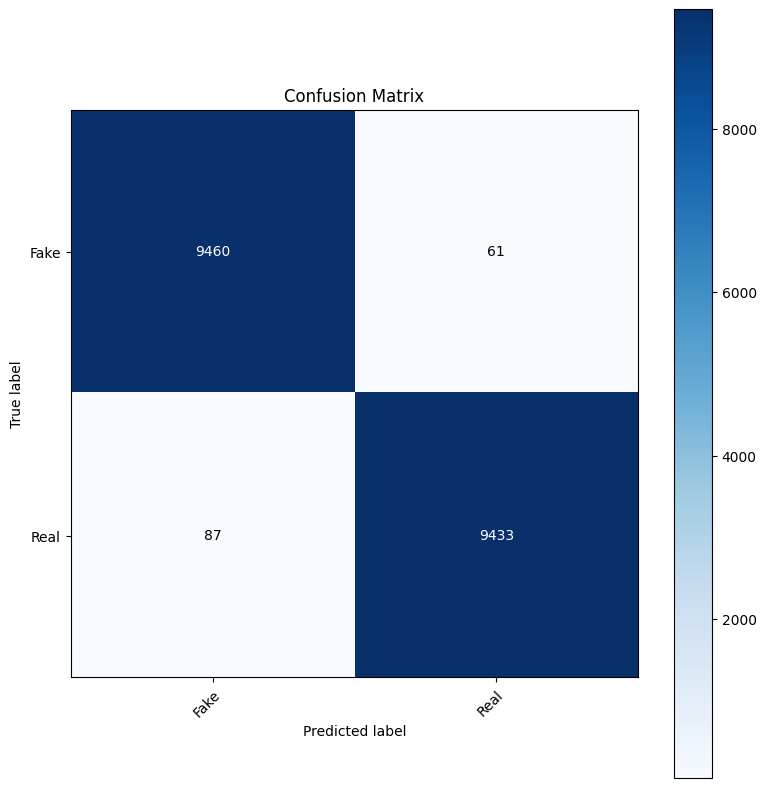


--- Generating ROC Curve ---
ROC curve saved to /content/drive/MyDrive/Deepfake_DiT/roc_curve.png


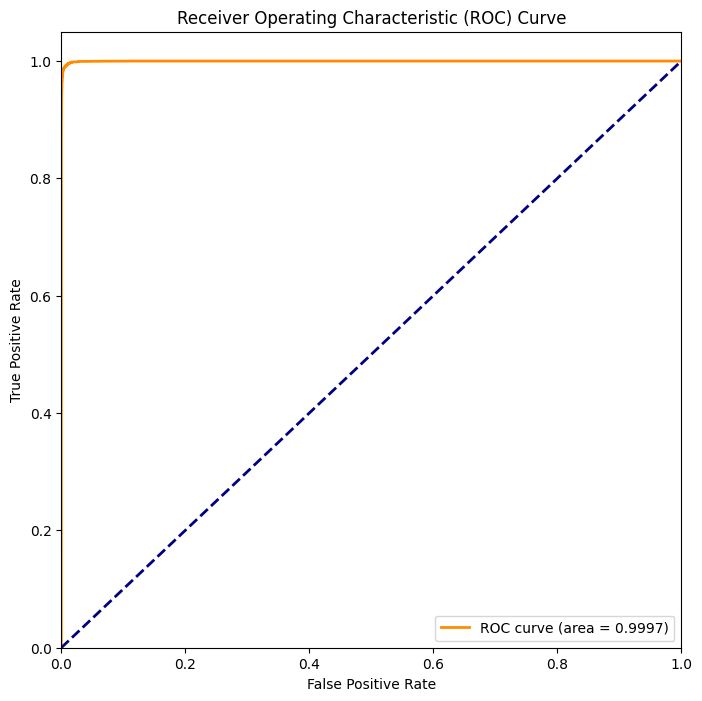


Script finished successfully.


In [11]:

# 7. EVALUATION AND VISUALIZATION
# =================================================================================================
print("\nStarting final evaluation...")

# Get predictions on the test set
outputs = trainer.predict(test_data)
y_true = outputs.label_ids
y_pred_logits = outputs.predictions
y_pred_labels = np.argmax(y_pred_logits, axis=1)
y_pred_probs = softmax(y_pred_logits, axis=1)[:, 1]

print("\n--- Final Evaluation Metrics ---")
print(outputs.metrics)

# --- Classification Report ---
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred_labels, target_names=labels_list, digits=4))

# --- Confusion Matrix ---
print("\n--- Generating Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred_labels)
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=labels_list, yticklabels=labels_list,
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/confusion_matrix.png")
print(f"Confusion matrix saved to {OUTPUT_DIR}/confusion_matrix.png")
plt.show()

# --- ROC Curve and AUROC ---
print("\n--- Generating ROC Curve ---")
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
auroc_score = roc_auc_score(y_true, y_pred_probs)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auroc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig(f"{OUTPUT_DIR}/roc_curve.png")
print(f"ROC curve saved to {OUTPUT_DIR}/roc_curve.png")
plt.show()

print("\nScript finished successfully.")

In [ ]:
# import shutil

# # Define source and destination paths
# source_dir = OUTPUT_DIR # OUTPUT_DIR is defined in cell HGXPIgzWC8iE
# destination_dir = '/kaggle/working/deepfake-vit-finetuned-tpu'

# # Copy the directory
# shutil.copytree(source_dir, destination_dir)

# print(f"Copied '{source_dir}' to '{destination_dir}'")

In [2]:
from huggingface_hub import HfApi
from google.colab import userdata

# 1. Authentication remains the same
HF_TOKEN = userdata.get('HF_TOKEN')
api = HfApi(token=HF_TOKEN)

# 2. Key change: Use the *existing* repository ID and specify the 'revision'
#    The revision can be a new branch name (e.g., 'v2') or a descriptive commit message.

api.upload_folder(
    folder_path="/content/drive/MyDrive/Deepfake_DiT/checkpoint-2678",
    # Use the existing V1 repo_id, assuming you want to update it or create a branch
    repo_id="sakshamkr1/deepfake-fb-deit-vit-224-v2", # Example V1 repo name
    repo_type="model",
    # *** Add a commit message to mark this as the V2 update (Option 1) ***
    commit_message="Model V2: checkpoint-2678, improved fine-tuning",
    # *** OR, use a new branch 'v2' for clear versioning (Option 2 - Recommended) ***
    # revision="v2",
    # Optional: Automatically create the repository if it doesn't exist
    # (only if you are using a new repo_id)
    # create_repo=True
)

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...nt-2678/training_args.bin: 100%|##########| 5.84kB / 5.84kB            

  ...kpoint-2678/rng_state.pth: 100%|##########| 14.5kB / 14.5kB            

  ...ckpoint-2678/scheduler.pt: 100%|##########| 1.47kB / 1.47kB            

  ...nt-2678/model.safetensors:   5%|4         | 16.7MB /  343MB            

  ...ckpoint-2678/optimizer.pt:   1%|1         | 8.36MB /  687MB            

CommitInfo(commit_url='https://huggingface.co/sakshamkr1/deepfake-fb-deit-vit-224-v2/commit/5e8747938d3e03b5812ac25c43b5f1abb9bddeb1', commit_message='Model V2: checkpoint-2678, improved fine-tuning', commit_description='', oid='5e8747938d3e03b5812ac25c43b5f1abb9bddeb1', pr_url=None, repo_url=RepoUrl('https://huggingface.co/sakshamkr1/deepfake-fb-deit-vit-224-v2', endpoint='https://huggingface.co', repo_type='model', repo_id='sakshamkr1/deepfake-fb-deit-vit-224-v2'), pr_revision=None, pr_num=None)